#Brain Tumor Image Classification

####Arturo Paras, Antonin Vigery, Victoria Han

In [ ]:
training_flag = False

##Model Card (CNN and logistic regression)
###Task Input and Output
The inputs of our models are images and the outputs are binary labels for classification.
###Training Data
We used brain image data from [Kaggle](https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset/data). We chose 80% of the data randomly for training, and 20% for validation. Our dataset is fairly "easy", i.e. a human can tell whether an image contains a tumor or not.
###Intended Use
Our models are intended for classification of CT scans of brains as normal or cancerous.
###Risks
Our models use a relatively small dataset for training and should not be the sole method used for diagnosis. Our models may produce false positives and false negatives.

##Introduction
We are interested in investigating image classification. In particular, the problem we are trying to solve is classifying images of brains as normal or cancerous. The inputs are brain scan images, and the outputs are labels ("tumor" or "normal").

##Methods

The first technique we use is a DenseNet CNN that we will train from scratch. The second technique we use is logistic regression. We are interested in exploring the effectiveness of training a CNN model versus logistic regression.

Our experimental question is: How do different CNN architectures and densities (number of convolutional layers) affect validation accuracy?

We used the following CNN architectures. You can select which architecture to use in the code.
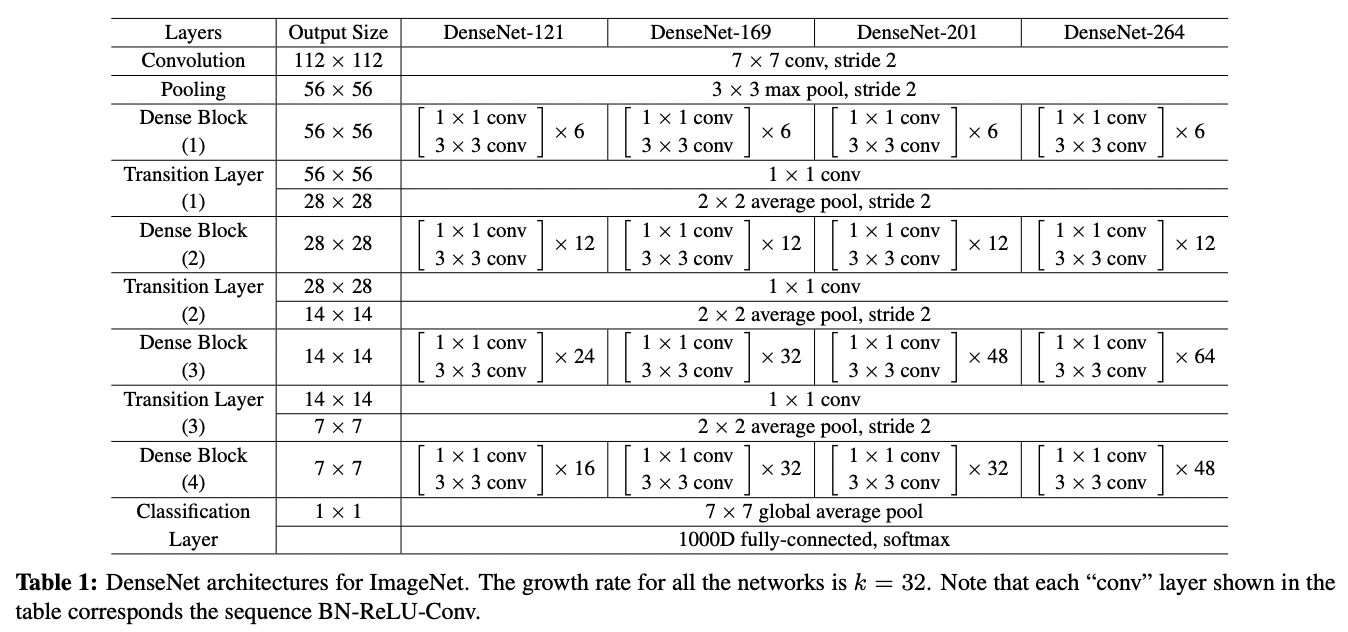

In [ ]:
!pip install split-folders
!pip install wandb
!pip install torcheval

import splitfolders
import torchvision.transforms as transforms
import torch
from torchsummary import summary
import torchvision
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import matplotlib.pyplot as plt
import wandb
from torch import nn
from torcheval.metrics import MulticlassAccuracy

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cpu


In [ ]:
!git clone https://github.com/vichan7/brain-tumor-images.git

fatal: destination path 'brain-tumor-images' already exists and is not an empty directory.


In [ ]:
DATA_DIR    = os.path.join("./brain-tumor-images/brain_imgs")

splitfolders.ratio(DATA_DIR, output='brain', seed=20, ratio=(0.8, 0.2))

DATA_DIR = os.path.join('/content/brain')

TRAIN_DIR   = os.path.join(DATA_DIR, "train")
VAL_DIR     = os.path.join(DATA_DIR, "val")


Copying files: 0 files [00:00, ? files/s]
Copying files: 240 files [00:00, 2399.08 files/s]
Copying files: 530 files [00:00, 2658.09 files/s]
Copying files: 796 files [00:00, 1970.85 files/s]
Copying files: 1009 files [00:00, 1721.04 files/s]
Copying files: 1201 files [00:00, 1776.27 files/s]
Copying files: 1401 files [00:00, 1840.07 files/s]
Copying files: 1614 files [00:00, 1923.94 files/s]
Copying files: 1823 files [00:00, 1971.62 files/s]
Copying files: 2025 files [00:01, 1962.94 files/s]
Copying files: 2225 files [00:01, 1876.37 files/s]
Copying files: 2543 files [00:01, 2244.90 files/s]
Copying files: 2853 files [00:01, 2491.01 files/s]
Copying files: 3107 files [00:01, 2480.48 files/s]
Copying files: 3436 files [00:01, 2716.29 files/s]
Copying files: 3758 files [00:01, 2862.77 files/s]
Copying files: 4049 files [00:01, 2875.43 files/s]
Copying files: 4600 files [00:01, 2360.91 files/s]


In [ ]:
cnn_config = {
    'batch_size'    : 64,
    'lr'            : 0.1,
    'epochs'        : 60,
    'momentum'      : 0.9,
    'weight_decay'  : 1e-4
}

logistic_config = {
    'batch_size'    : 64,
    'lr'            : 1e-4,
    'epochs'        : 20,
    'weight_decay'  : 1e-5
}

In [ ]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.Normalize(mean=[0.2455, 0.2457, 0.2458], std=[0.2560, 0.2561, 0.2562]),
    ])

valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.Normalize(mean=[0.2455, 0.2457, 0.2458], std=[0.2560, 0.2561, 0.2562]),
    ])

train_dataset = torchvision.datasets.ImageFolder(TRAIN_DIR, transform = train_transforms)
valid_dataset = torchvision.datasets.ImageFolder(VAL_DIR, transform = valid_transforms)

cnn_train_loader = torch.utils.data.DataLoader(dataset      = train_dataset,
                                               batch_size   = cnn_config['batch_size'],
                                               shuffle      = True,
                                               pin_memory   = True)

logistic_train_loader = torch.utils.data.DataLoader(dataset      = train_dataset,
                                                    batch_size   = logistic_config['batch_size'],
                                                    shuffle      = True,
                                                    pin_memory   = True)

cnn_valid_loader = torch.utils.data.DataLoader(dataset      = valid_dataset,
                                               batch_size   = cnn_config['batch_size'],
                                               shuffle      = False)

logistic_valid_loader = torch.utils.data.DataLoader(dataset      = train_dataset,
                                                    batch_size   = logistic_config['batch_size'],
                                                    shuffle      = False)

Run the cell below to see a sample of our data.

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


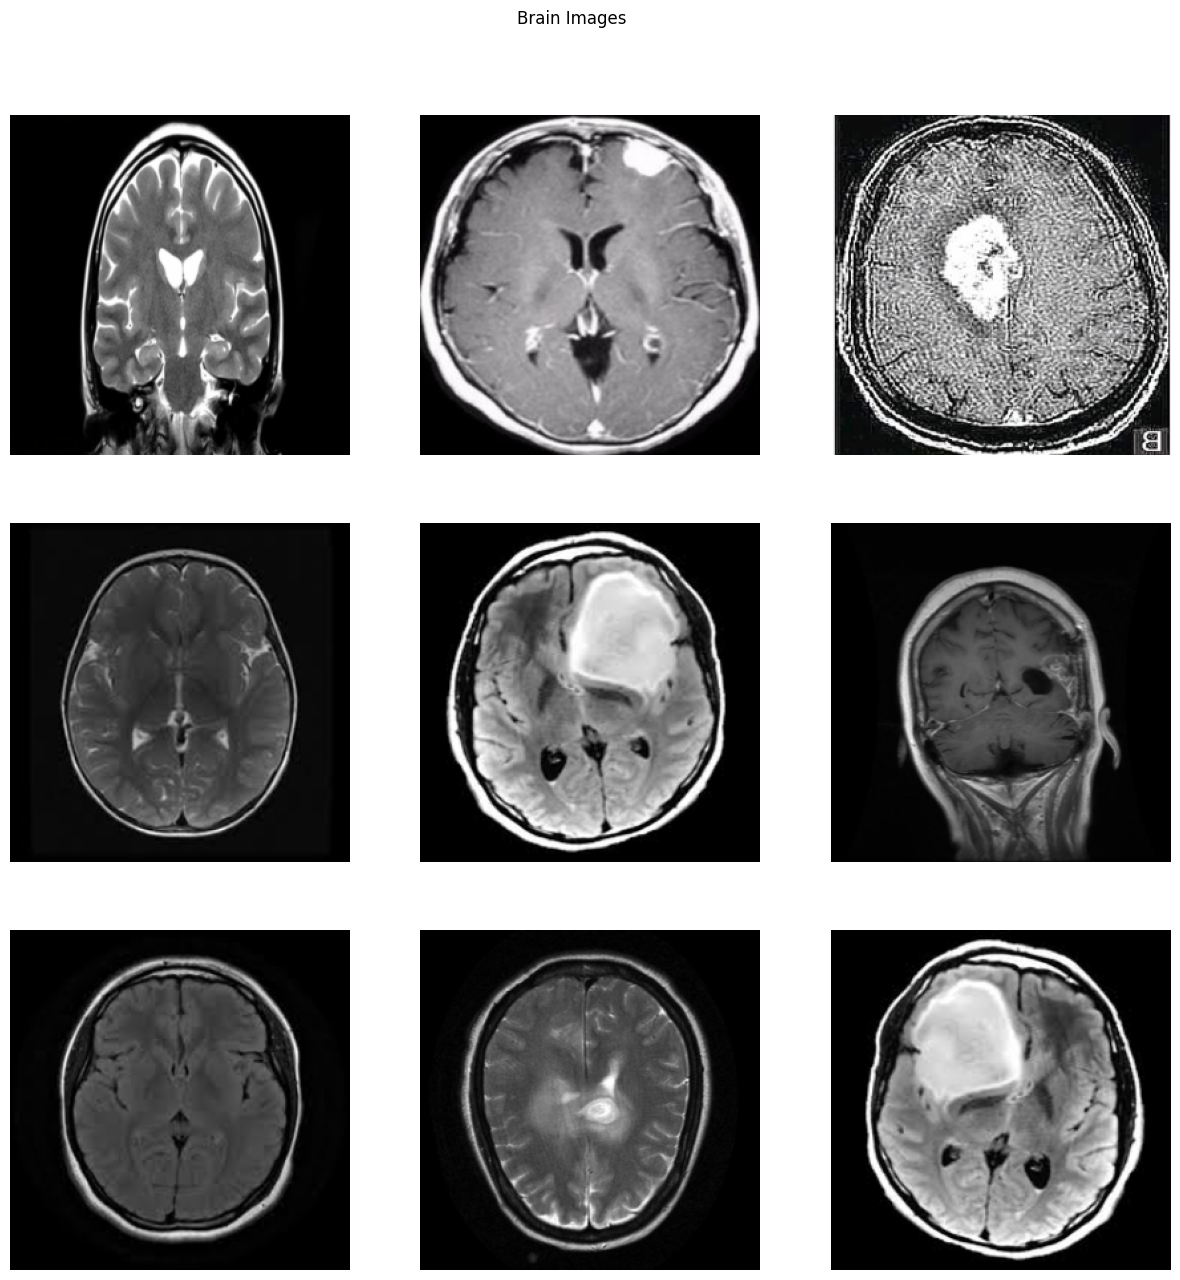

In [ ]:
figure = plt.figure(figsize=(15,15))
for i in range(1,10):
    sample_idx = torch.randint(len(valid_dataset), size=(1,)).item()
    img, label = valid_dataset[sample_idx]
    figure.add_subplot(3, 3, i)
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    print(img_np.shape)
    max = img_np.max()
    min = img_np.min()
    img_valid_range = (img_np - min) / (max - min)
    plt.imshow(img_valid_range)
    plt.suptitle('Brain Images', y=0.95)

In [ ]:
# Choose which densenet architecture to run. Options are 201, 121, 169, 264
densenet = 264

In [ ]:
class DenseLayer(torch.nn.Module):

    def __init__(self, in_channels, growth_rate, bn_size):
        super().__init__()

        self.bn1 = torch.nn.BatchNorm2d(in_channels)
        self.relu1 = torch.nn.ReLU()
        self.conv1 = torch.nn.Conv2d(in_channels, bn_size*growth_rate, kernel_size=1, stride=1, padding=0, bias=False)

        self.bn2 = torch.nn.BatchNorm2d(bn_size*growth_rate)
        self.relu2 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(bn_size*growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(self.relu1(self.bn1(x)))
        out = self.conv2(self.relu1(self.bn2(out)))
        return torch.cat([x, out], 1)

class DenseBlock(torch.nn.Module):
    def __init__(self, in_channels, growth_rate, bn_size, num_layers):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(DenseLayer(in_channels+i*growth_rate, growth_rate, bn_size))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Transition(torch.nn.Module):
    def __init__(self, in_channels, compression):
        super().__init__()
        self.bn = torch.nn.BatchNorm2d(in_channels)
        self.relu = torch.nn.ReLU()
        self.conv = torch.nn.Conv2d(in_channels, int(compression*in_channels), kernel_size=1, stride=1, padding=0, bias=False)
        self.pool = torch.nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        out = self.conv(self.relu(self.bn(x)))
        out = self.pool(out)
        return out

class Network(torch.nn.Module):

    def __init__(self, num_classes=7001):
        super().__init__()
        if densenet == 201:
            self.config = [6, 12, 48, 32]
        if densenet == 121:
            self.config = [6, 12, 24, 16]
        if densenet == 169:
            self.config = [6, 12, 32, 32]
        if densenet == 264:
            self.config = [6, 12, 64, 48]
        self.bn_size = 4
        self.growth_rate = 32
        self.in_channels = 1
        self.num_classes = 7001
        self.num_features_base = 64
        self.compression = 0.5
        self.after_block = [64+self.growth_rate*self.config[0]]
        for i in range(1, 4):
          self.after_block.append(self.after_block[i-1]+self.growth_rate*self.config[i])

        if densenet == 201:
            self.backbone = torch.nn.Sequential(

                #DenseNet architecture

                torch.nn.Conv2d(3, 64, 7, 2, 1, bias=False),
                torch.nn.BatchNorm2d(64),
                torch.nn.ReLU(),

                torch.nn.MaxPool2d(2, 2),

                DenseBlock(64, self.growth_rate, self.bn_size, self.config[0]),
                Transition(256, self.compression),

                DenseBlock(128, self.growth_rate, self.bn_size, self.config[1]),
                Transition(512, self.compression),

                DenseBlock(256, self.growth_rate, self.bn_size, self.config[2]),
                Transition(1792, self.compression),

                DenseBlock(896, self.growth_rate, self.bn_size, self.config[3]),

                torch.nn.BatchNorm2d(1920),
                # torch.nn.ReLU(),

                torch.nn.AdaptiveAvgPool2d(1),

                torch.nn.Flatten()

                )

            self.cls_layer = torch.nn.Linear(1920, num_classes)

        if densenet == 121:
            self.backbone = torch.nn.Sequential(

                #DenseNet architecture

                torch.nn.Conv2d(3, 64, 7, 2, 1, bias=False),
                torch.nn.BatchNorm2d(64),
                torch.nn.ReLU(),

                torch.nn.MaxPool2d(2, 2),

                DenseBlock(64, self.growth_rate, self.bn_size, self.config[0]),
                Transition(256, self.compression),

                DenseBlock(128, self.growth_rate, self.bn_size, self.config[1]),
                Transition(512, self.compression),

                DenseBlock(256, self.growth_rate, self.bn_size, self.config[2]),
                Transition(1024, self.compression),

                DenseBlock(512, self.growth_rate, self.bn_size, self.config[3]),

                torch.nn.BatchNorm2d(1024),
                # torch.nn.ReLU(),

                torch.nn.AdaptiveAvgPool2d(1),

                torch.nn.Flatten()

                )

            self.cls_layer = torch.nn.Linear(1024, num_classes)
        if densenet == 169:
            self.backbone = torch.nn.Sequential(

                #DenseNet architecture

                torch.nn.Conv2d(3, 64, 7, 2, 1, bias=False),
                torch.nn.BatchNorm2d(64),
                torch.nn.ReLU(),

                torch.nn.MaxPool2d(2, 2),

                DenseBlock(64, self.growth_rate, self.bn_size, self.config[0]),
                Transition(256, self.compression),

                DenseBlock(128, self.growth_rate, self.bn_size, self.config[1]),
                Transition(512, self.compression),

                DenseBlock(256, self.growth_rate, self.bn_size, self.config[2]),
                Transition(1280, self.compression),

                DenseBlock(640, self.growth_rate, self.bn_size, self.config[3]),

                torch.nn.BatchNorm2d(1664),
                # torch.nn.ReLU(),

                torch.nn.AdaptiveAvgPool2d(1),

                torch.nn.Flatten()

                )

            self.cls_layer = torch.nn.Linear(1664, num_classes)

        if densenet == 264:
            self.backbone = torch.nn.Sequential(

                #DenseNet architecture

                torch.nn.Conv2d(3, 64, 7, 2, 1, bias=False),
                torch.nn.BatchNorm2d(64),
                torch.nn.ReLU(),

                torch.nn.MaxPool2d(2, 2),

                DenseBlock(64, self.growth_rate, self.bn_size, self.config[0]),
                Transition(256, self.compression),

                DenseBlock(128, self.growth_rate, self.bn_size, self.config[1]),
                Transition(512, self.compression),

                DenseBlock(256, self.growth_rate, self.bn_size, self.config[2]),
                Transition(2304, self.compression),

                DenseBlock(1152, self.growth_rate, self.bn_size, self.config[3]),

                torch.nn.BatchNorm2d(2688),
                # torch.nn.ReLU(),

                torch.nn.AdaptiveAvgPool2d(1),

                torch.nn.Flatten()

                )

            self.cls_layer = torch.nn.Linear(2688, num_classes)


    def forward(self, x, return_feats=False):

        feats = self.backbone(x)
        out = self.cls_layer(feats)

        if return_feats:
            return feats
        else:
            return out

# Initialize your model
if training_flag:
    cnn_model = Network().to(DEVICE)
    summary(cnn_model, (3, 224, 224))


In [ ]:
if training_flag:
    cnn_criterion = torch.nn.CrossEntropyLoss()
    cnn_optimizer = torch.optim.SGD(cnn_model.parameters(),
                                    lr=cnn_config['lr'],
                                    momentum=cnn_config['momentum'],
                                    weight_decay=cnn_config['weight_decay'])
    cnn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(cnn_optimizer, patience=1, factor=0.5)
    scaler = torch.cuda.amp.GradScaler()

In [ ]:
if training_flag:
    def cnn_train(model, dataloader, optimizer, criterion):

        model.train()

        # Progress Bar
        batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

        num_correct = 0
        total_loss  = 0

        for i, (images, labels) in enumerate(dataloader):

            optimizer.zero_grad()

            images, labels = images.to(DEVICE), labels.to(DEVICE)

            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss    = criterion(outputs, labels)

            # Update no. of correct predictions & loss as we iterate
            num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
            total_loss      += float(loss.item())

            # tqdm lets you add some details so you can monitor training as you train.
            batch_bar.set_postfix(
                acc         = "{:.04f}%".format(100 * num_correct / (cnn_config['batch_size']*(i + 1))),
                loss        = "{:.04f}".format(float(total_loss / (i + 1))),
                num_correct = num_correct,
                lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
            )

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            batch_bar.update()

        batch_bar.close()

        acc         = 100 * num_correct / (cnn_config['batch_size']* len(dataloader))
        total_loss  = float(total_loss / len(dataloader))

        return acc, total_loss

    def validate(model, dataloader, criterion):

        model.eval()
        batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

        num_correct = 0.0
        total_loss = 0.0

        for i, (images, labels) in enumerate(dataloader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            # print(labels)

            with torch.inference_mode():
                outputs = model(images)
                loss = criterion(outputs, labels)

            num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
            total_loss += float(loss.item())

            batch_bar.set_postfix(
                acc="{:.04f}%".format(100 * num_correct / (cnn_config['batch_size']*(i + 1))),
                loss="{:.04f}".format(float(total_loss / (i + 1))),
                num_correct=num_correct)

            batch_bar.update()

        batch_bar.close()
        acc = 100 * num_correct / (cnn_config['batch_size']* len(dataloader))
        total_loss = float(total_loss / len(dataloader))
        return acc, total_loss

In [ ]:
if training_flag:
    wandb.login(key="a3e77f215cc318aea72356490db397ff98ee38f4")
    run = wandb.init(
        name = "densenet-264", ## Wandb creates random run names if you skip this field
        reinit = True, ### Allows reinitalizing runs when you re-run this cell
        project = "10-315",
        config = cnn_config
    )

In [ ]:
if training_flag:
    best_class_acc      = 0.0
    best_ver_acc        = 0.0

    torch.cuda.empty_cache()
    gc.collect()

    for epoch in range(cnn_config['epochs']):

        curr_lr = float(cnn_optimizer.param_groups[0]['lr'])

        train_acc, train_loss = cnn_train(cnn_model, cnn_train_loader, cnn_optimizer, cnn_criterion)

        print("\nEpoch {}/{}: \nTrain Acc (Classification) {:.04f}%\t Train Loss (Classification) {:.04f}\t Learning Rate {:.07f}".format(
            epoch + 1, cnn_config['epochs'], train_acc, train_loss, curr_lr))

        val_acc, val_loss = validate(cnn_model, cnn_valid_loader, cnn_criterion)
        print("Val Acc (Classification) {:.04f}%\t Val Loss (Classification) {:.04f}".format(val_acc, val_loss))
        cnn_scheduler.step(val_loss)

        wandb.log({"train_classification_acc": train_acc,
                  "train_classification_loss":train_loss,
                  "val_classification_acc": val_acc,
                  "val_classification_loss": val_loss,
                  "learning_rate": curr_lr})

        if val_acc >= best_class_acc:
            print(val_acc, best_class_acc)
            best_class_acc = val_acc
            wandb.save('checkpoint_densenet_264.pth')
            print("Saved best classification model")

    wandb.finish()


In [ ]:
class LogisticReg(nn.Module):
    def __init__(self, bottleneck=2):
        super().__init__()
        self.linear = nn.Linear(3 * 256 * 256, 2)

    def forward(self, x):
        return self.linear(x)


In [ ]:
if training_flag:
    if torch.cuda.is_available():
        logistic_model = LogisticReg().cuda()
    else:
        logistic_model = LogisticReg()

    logistic_criterion = nn.CrossEntropyLoss()
    logistic_optimizer = torch.optim.AdamW(logistic_model.parameters(), lr=logistic_config['lr'], weight_decay=logistic_config['weight_decay'])
    logistic_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(logistic_optimizer, patience=1, factor=0.5)
    train_metric = MulticlassAccuracy(device=DEVICE)
    valid_metric = MulticlassAccuracy(device=DEVICE)

In [ ]:
if training_flag:
    def predict(img):
        dims = img.size()
        if len(dims) == 3:
            img = torch.reshape(img, (1, 3 * 256 * 256))
        else:
            img = torch.reshape(img, (dims[0], 3 * 256 * 256))
        return logistic_model(img)

In [ ]:
if training_flag:
    wandb.login(key="a3e77f215cc318aea72356490db397ff98ee38f4")
    run = wandb.init(
    name = "logistic_regression", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    project = "10-315",
    config = logistic_config
)

In [ ]:
if training_flag:
    num_epochs = logistic_config['epochs']

    train_loss_values = []
    valid_loss_values = []
    train_accuracy_values = []
    valid_accuracy_values = []
    weights = []

    for epoch in range(num_epochs):
        for data in logistic_train_loader:
            img, labels = data

            if torch.cuda.is_available():
                img = img.cuda()
                labels = labels.cuda()

            output = predict(img)
            train_loss = logistic_criterion(output, labels)
            train_metric.update(output, labels)



            logistic_optimizer.zero_grad()
            train_loss.backward()
            logistic_optimizer.step()


        for data in logistic_valid_loader:
            img, labels = data

            if torch.cuda.is_available():
                img = img.cuda()
                labels = labels.cuda()

            output = predict(img)
            valid_loss = logistic_criterion(output, labels)
            valid_metric.update(output, labels)

        logistic_scheduler.step(valid_loss)

        # Print/plot progress
        print(f'Epoch {epoch+1} of {num_epochs}:  train loss={train_loss.data:.4f} train accuracy={train_metric.compute().data:.4f}')
        print(f'Epoch {epoch+1} of {num_epochs}:  valid loss={valid_loss.data:.4f} valid accuracy={valid_metric.compute().data:.4f}')
        print()

        wandb.log({"train_classification_acc": train_metric.compute().data.detach().cpu() * 100,
                  "train_classification_loss":train_loss.data.detach().cpu(),
                  "val_classification_acc": valid_metric.compute().data.detach().cpu() * 100,
                  "val_classification_loss": valid_loss.data.detach().cpu(),
                  "learning_rate": logistic_optimizer.param_groups[0]["lr"]})

        # Track loss, accuracy, and weights
        weights.append(logistic_model.state_dict()["linear.weight"].detach().cpu())

        # Reset accuracy each epoch
        train_metric.reset()
        valid_metric.reset()

    wandb.finish()


##Results and Discussion

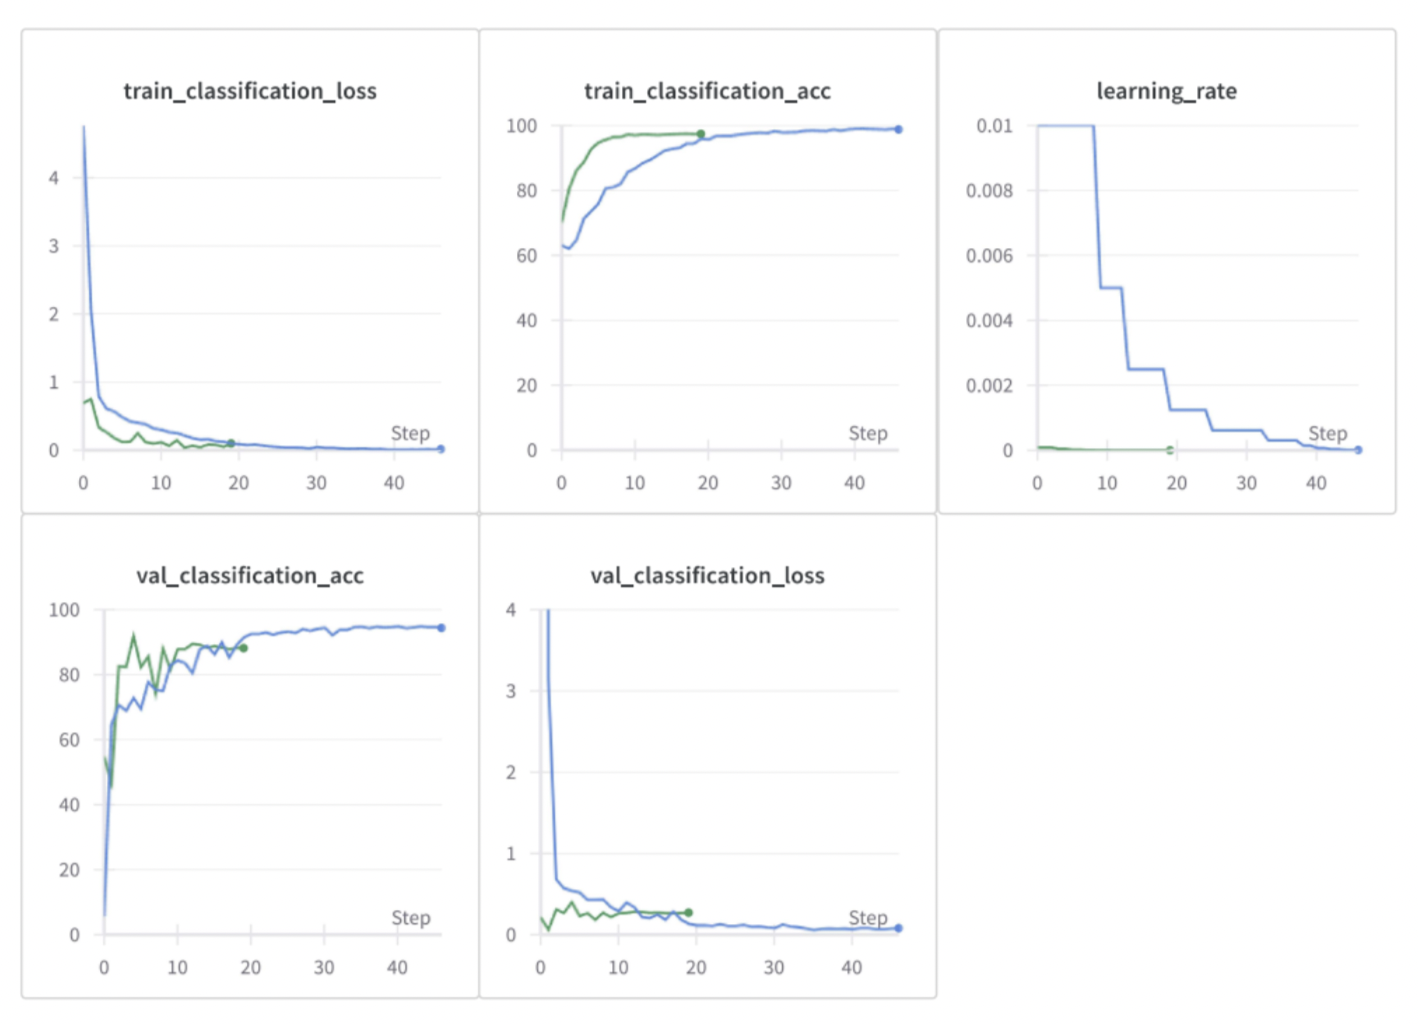

In the above plots, the blue line represents the DenseNet-264 CNN and the green line represents logistic regression. Logistic regression starts with higher accuracy and appears to converge faster (at 20 epochs) than the CNN for training and validation accuracy. The logistic regression model and the CNN have the same training accuracy after convergence. However, the CNN has higher validation accuracy (around 95%) than the logistic regression model (around 90%). Thus, it appears that although the CNN takes longer to reach convergence, it is more effective at classifying brain scans as healthy or cancerous. This is what we expected, since logistic regression is a much simpler model than the CNN, so it's expected to converge faster but be less accurate. One limitation of logistic regression is that it is incapable of capturing non-linearities since it only has one layer. CNNs can be limited in effectiveness due to inductive biases.

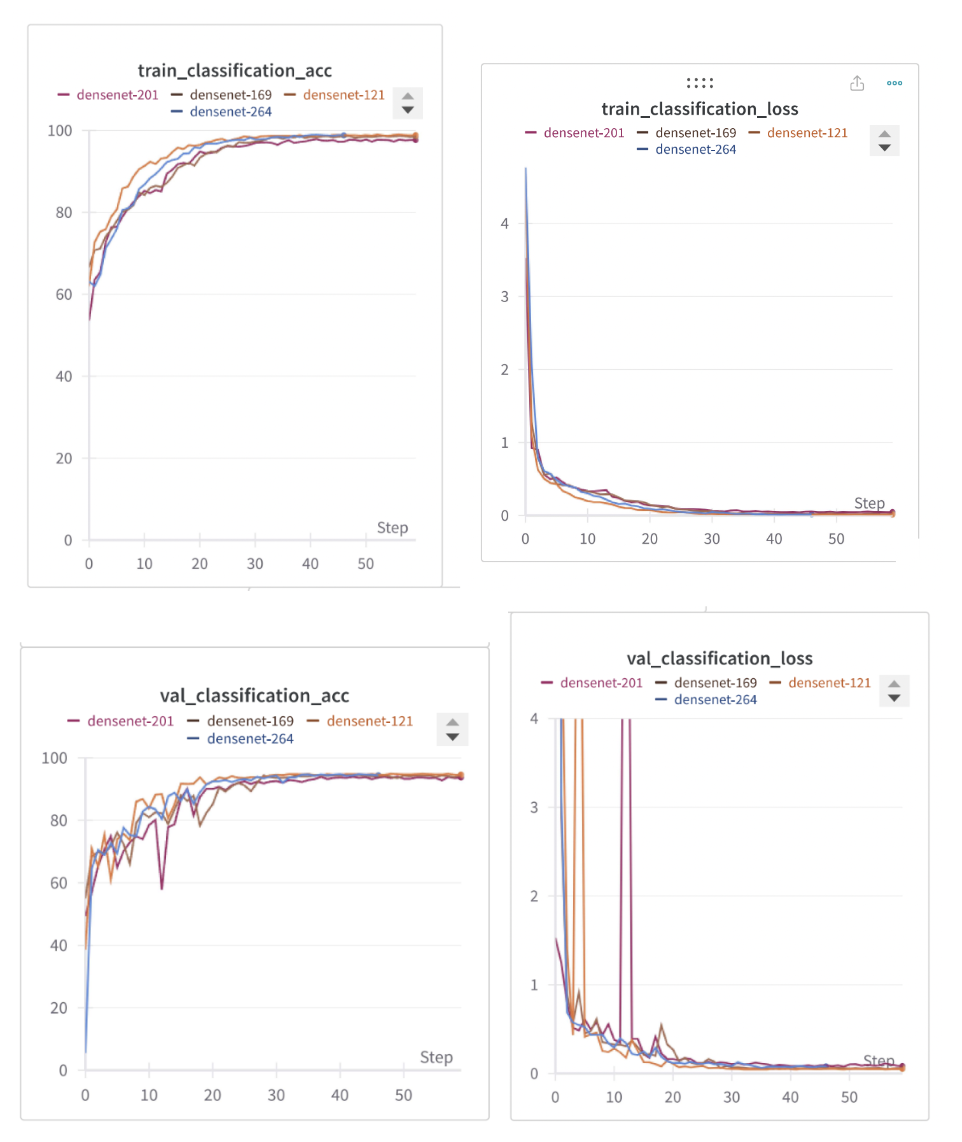

All of the different CNN architectures appear to have very similar training and validation accuracy. They also take about the same number of epochs to converge. The DenseNet-121 and DenseNet-264 CNNs have the highest validation accuracy. This is not what we expected, since we expected the CNN with the most parameters (the DenseNet-264 CNN) to perform the  best. This may be due to not having a large enough dataset or not enough epochs during training.

##References

Huang, Gao, et al. "Densely connected convolutional networks." Proceedings of the IEEE conference on computer vision and pattern recognition. 2017. [paper link](https://arxiv.org/pdf/1608.06993): code for the CNNs is our implementation of this paper.

[digit_logistic_regression.ipynb](https://drive.google.com/file/d/1Vmt8luUbESNyM3dJDoHhb-7tXpmbzmAc/view?usp=drive_link): code in the cell defining the class LogisticRegression and in the cell doing the logistic regression training contains code from this notebook.



